# Importing the Packages

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from pandas import datetime

In [5]:
import seaborn as sns

In [6]:
import math, time

In [7]:
import itertools

In [8]:
import datetime

In [9]:
from operator import itemgetter

In [10]:
from sklearn import preprocessing

In [11]:
from sklearn.metrics import mean_squared_error

In [12]:
from math import sqrt

In [13]:
from keras.models import Sequential

Using TensorFlow backend.


In [14]:
from keras.layers.core import Dense, Dropout, Activation

In [15]:
from keras.layers.recurrent import LSTM

In [16]:
from keras.models import load_model

In [17]:
import keras

In [18]:
import h5py

In [19]:
import requests

In [20]:
import os

# Reading the Data

In [21]:
adjusted = pd.read_csv("./prices-split-adjusted.csv", index_col = 0)
adjusted["adj close"] = adjusted.close # Moving close to the last column
adjusted.drop(['close'], 1, inplace=True) # Moving close to the last column
adjusted.head()

,symbol,open,low,high,volume,adj close
date,,,,,,
2016-01-05,WLTW,123.430000,122.309998,126.250000,2163600.0,125.839996
2016-01-06,WLTW,125.239998,119.940002,125.540001,2386400.0,119.980003
2016-01-07,WLTW,116.379997,114.930000,119.739998,2489500.0,114.949997
2016-01-08,WLTW,115.480003,113.500000,117.440002,2006300.0,116.620003
2016-01-11,WLTW,117.010002,114.089996,117.330002,1408600.0,114.970001


In [22]:
fundamentals = pd.read_csv("./fundamentals.csv")
fundamentals.head()

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


# Looking for NaN Values

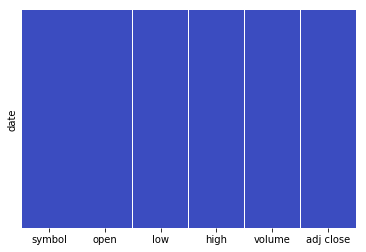

In [23]:
sns.heatmap(adjusted.isnull(),yticklabels=False,cbar=False,cmap='coolwarm')

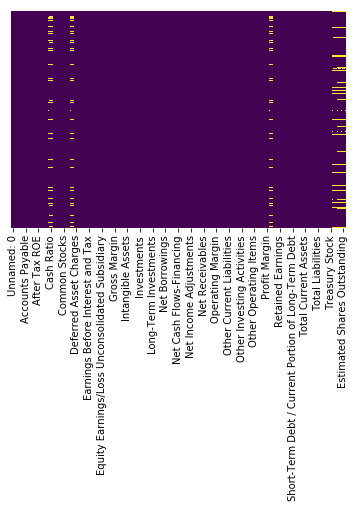

In [24]:
sns.heatmap(fundamentals.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Let's get to work!

# Extracting Symbols from List

In [25]:
symbols = list(set(adjusted.symbol))
len(symbols)

501

In [26]:
symbols[:15] # Example of what is in symbols

['ECL',
 'HON',
 'RAI',
 'BSX',
 'COG',
 'WLTW',
 'CAH',
 'KHC',
 'DVA',
 'GOOGL',
 'DIS',
 'DTE',
 'FDX',
 'AVGO',
 'CSX']

# Ralph Lauren as an Example

In [27]:
adjusted = adjusted[adjusted.symbol == 'RL']
adjusted.drop(['symbol'],1,inplace=True)
adjusted.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,81.839996,80.180000,81.900002,899700.0,81.559998
2010-01-05,81.370003,80.830002,84.989998,2044900.0,84.760002
2010-01-06,84.739998,83.779999,85.230003,873000.0,84.120003
2010-01-07,84.150002,84.120003,86.489998,1106900.0,85.739998
2010-01-08,85.300003,84.720001,86.489998,1202100.0,86.370003


# Normalize the Data

In [28]:
def normalize_data(adjusted):
    min_max_scaler = preprocessing.MinMaxScaler()
    adjusted['open'] = min_max_scaler.fit_transform(adjusted.open.values.reshape(-1,1))
    adjusted['high'] = min_max_scaler.fit_transform(adjusted.high.values.reshape(-1,1))
    adjusted['low'] = min_max_scaler.fit_transform(adjusted.low.values.reshape(-1,1))
    adjusted['volume'] = min_max_scaler.fit_transform(adjusted.volume.values.reshape(-1,1))
    adjusted['adj close'] = min_max_scaler.fit_transform(adjusted['adj close'].values.reshape(-1,1))
    return adjusted
adjusted = normalize_data(adjusted)
adjusted.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,0.086938,0.077575,0.066774,0.069055,0.081867
2010-01-05,0.082944,0.083141,0.092958,0.169835,0.109071
2010-01-06,0.111583,0.108400,0.094992,0.066705,0.103630
2010-01-07,0.106569,0.111311,0.105669,0.087289,0.117402
2010-01-08,0.116342,0.116448,0.105669,0.095667,0.122758


# Creating the Train Test Split

In [30]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 30 days
    
    result = np.array(result)
    row = round(0.8 * result.shape[0]) # 80% split
    train = result[:int(row), :] # 80% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

# Building Layers

In [31]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

# Training the Model

In [32]:
window = 30
X_train, y_train, X_test, y_test = load_data(adjusted, window)
print (X_train[0], y_train[0])

[[0.08693801 0.07757511 0.06677404 0.06905504 0.08186686]
 [0.08294384 0.08314067 0.09295823 0.16983473 0.10907083]
 [0.11158322 0.10839966 0.094992   0.06670539 0.10363005]
 [0.10656923 0.1113109  0.10566902 0.08728902 0.11740201]
 [0.11634233 0.11644831 0.10566902 0.09566679 0.12275783]
 [0.12637038 0.11876012 0.1097365  0.08620659 0.11587179]
 [0.11362286 0.10343346 0.09863577 0.06618618 0.10107966]
 [0.10741905 0.10822843 0.10126264 0.0626749  0.11706195]
 [0.11515257 0.11593459 0.09846625 0.0336079  0.11204626]
 [0.10962863 0.1006935  0.09753412 0.07590158 0.10116469]
 [0.10444464 0.10874216 0.09253457 0.04232888 0.1091558 ]
 [0.10631429 0.10822843 0.10583853 0.16130736 0.12301286]
 [0.12433073 0.11113961 0.10956698 0.10490698 0.1066905 ]
 [0.11039345 0.09213112 0.09295823 0.07924565 0.08594747]
 [0.09492647 0.09332986 0.07965427 0.06199729 0.09215334]
 [0.092292   0.09358678 0.08126433 0.04855061 0.09045312]
 [0.09178213 0.09110368 0.07863745 0.04049844 0.09419368]
 [0.09858076 0

/home/atse/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
model = build_model([5,window,1])

Compilation Time :  0.10014891624450684


In [34]:
model.fit(X_train,y_train,batch_size=512,epochs=100,validation_split=0.1,verbose=1)

Train on 1246 samples, validate on 139 samples
Epoch 1/100
1246/1246 [==============================] - 31s 25ms/step - loss: 0.4214 - acc: 8.0257e-04 - val_loss: 0.1629 - val_acc: 0.0000e+00
Epoch 2/100
1246/1246 [==============================] - 14s 11ms/step - loss: 0.1764 - acc: 8.0257e-04 - val_loss: 0.0830 - val_acc: 0.0000e+00
Epoch 3/100
1246/1246 [==============================] - 12s 9ms/step - loss: 0.0906 - acc: 8.0257e-04 - val_loss: 0.0482 - val_acc: 0.0000e+00
Epoch 4/100
1246/1246 [==============================] - 13s 11ms/step - loss: 0.0640 - acc: 8.0257e-04 - val_loss: 0.0043 - val_acc: 0.0000e+00
Epoch 5/100
1246/1246 [==============================] - 12s 10ms/step - loss: 0.0675 - acc: 8.0257e-04 - val_loss: 0.0045 - val_acc: 0.0000e+00
Epoch 6/100
1246/1246 [==============================] - 11s 9ms/step - loss: 0.0577 - acc: 0.0016 - val_loss: 0.0063 - val_acc: 0.0000e+00
Epoch 7/100
1246/1246 [==============================] - 14s 11ms/step - loss: 0.0259 - a

Epoch 59/100
1246/1246 [==============================] - 6s 5ms/step - loss: 0.0028 - acc: 0.0016 - val_loss: 0.0035 - val_acc: 0.0000e+00
Epoch 60/100
1246/1246 [==============================] - 6s 5ms/step - loss: 0.0027 - acc: 0.0016 - val_loss: 0.0030 - val_acc: 0.0000e+00
Epoch 61/100
1246/1246 [==============================] - 6s 5ms/step - loss: 0.0027 - acc: 0.0016 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 62/100
1246/1246 [==============================] - 6s 5ms/step - loss: 0.0027 - acc: 0.0016 - val_loss: 0.0035 - val_acc: 0.0000e+00
Epoch 63/100
1246/1246 [==============================] - 6s 5ms/step - loss: 0.0029 - acc: 0.0016 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 64/100
1246/1246 [==============================] - 13s 11ms/step - loss: 0.0026 - acc: 0.0016 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 65/100
1246/1246 [==============================] - 7s 6ms/step - loss: 0.0028 - acc: 0.0016 - val_loss: 0.0025 - val_acc: 0.0000e+00
Epoch 66/100
1246/

In [35]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
print (p.shape)
# for each data index in test data
for u in range(len(y_test)):
    # pr = prediction day u
    pr = p[u][0]
    # (y_test day u / pr) - 1
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    # print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))
    # Last day prediction
    # print(p[-1]) 

(346, 1)


# Denormalize the Data

In [36]:
adj2 = pd.read_csv("./prices-split-adjusted.csv", index_col = 0)
adj2["adj close"] = adj2.close # Moving close to the last column
adj2.drop(['close'], 1, inplace=True) # Moving close to the last column
adj2 = adj2[adj2.symbol == 'RL']
adj2.drop(['symbol'],1,inplace=True)

# Bug fixed at here, please update the denormalize function to this one
def denormalize(adj2, normalized_value): 
    adj2 = adj2['adj close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(adj2)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(adj2, p)
newy_test = denormalize(adj2, y_test)

# Creating a Model Score

In [37]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00153 MSE (0.04 RMSE)
Test Score: 0.00216 MSE (0.05 RMSE)


(0.001527743626786026, 0.0021634936720305096)

# Creating Visualizations

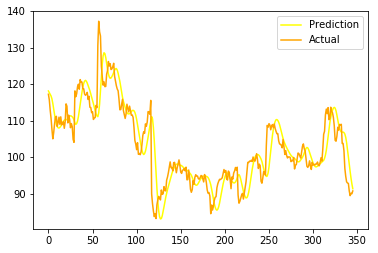

In [38]:
import matplotlib.pyplot as plt2

plt2.plot(newp,color='yellow', label='Prediction')
plt2.plot(newy_test,color='orange', label='Actual')
plt2.legend(loc='best')
plt2.show()

By looking at the analysis for the performance in the Ralph Lauren stock, it has been determined that the prediction and the actual values are almost close to similar. This time-series forecast is ran on a 30-day period. There will be more examples provided by doing different methods and different examples for this problem. 